In [65]:
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

allowed_color = 'Green'
polylog_color = 'Black'
noyhat_color = 'Orange'
giantstep_color = 'Blue'
notallowed_color = 'Red'
processnotdefined_color = 'Purple'
sweetspot_color = 'cyan'

In [66]:
from giant_learning.gradient_descent import SphericalGradientDescent
from giant_learning.erf_erf import SphericalErfErfOverlaps

import numpy as np
from sklearn.preprocessing import normalize
from scipy.linalg import orth
from tqdm import tqdm


target = SphericalErfErfOverlaps._target
activation = SphericalErfErfOverlaps._activation
activation_derivative = SphericalErfErfOverlaps._activation_derivative

perfectlearning_color = 'Green'
saadsolla_color = 'Teal'
badlearning_color = 'Red'

p = 2
k = 2
d = 10000

n = [int(np.power(d,1/4)), int(np.power(d,1/2)), int(np.power(d,1/2))]

## Plot Table
labels_simulations = [f'Noise Learning', f'Saad\&Solla', f'Population Flow']
labels_theory = [f'Theory, Noise Learning', f'Theory, Saad\&Solla', f'Theory, Population Flow']
gammas = 10.*p*np.array([.015*np.power(d,-2/16),.4*np.power(d,-1/2),.5*np.power(d,-1.)])
I3activated = [False,True, True]
I4_diagonalactivated = [d/n[0],d/n[1], False]
I4_offdiagonalactivated = [True,False, False]
colors = [badlearning_color,saadsolla_color, perfectlearning_color]
scaling = np.array([1.,1.,1.])
print(scaling)

t = 0
noise = 1e-2

T = 100000

seed = [2,1,2]
read_simulation = True

# Initial conditions
Wtarget = orth((normalize(np.random.normal(size=(k,d)), axis=1, norm='l2')).T).T
Wtild = normalize(np.random.normal(size=(p,d)), axis=1, norm='l2')
Wtild_target = np.einsum('ji,ri,rh->jh', Wtild , Wtarget ,Wtarget)
W0_orth =  normalize(Wtild - Wtild_target, axis=1, norm='l2')
W0 = (t*normalize(Wtild_target,norm='l2',axis=1) + np.sqrt(1-t**2)*W0_orth)
a0 = np.ones(p) 

P = Wtarget @ Wtarget.T
M0 = W0 @ Wtarget.T
Q0 = W0 @ W0.T

test_errors_simulation = np.zeros((len(gammas), T+1))
test_errors_theory = np.zeros((len(gammas), T+1))


for i,gamma in enumerate(gammas):
    gd = SphericalGradientDescent(
        target, Wtarget, n[i],
        activation, W0, a0, activation_derivative, 
        gamma, noise, second_layer_update = False, test_size = None, analytical_error= 'erferf',
        seed=seed[i]^i
    )
    th = SphericalErfErfOverlaps(
        P, M0, Q0, a0,
        gamma, noise,
        I4_diagonal=I4_diagonalactivated[i], I4_offdiagonal=I4_offdiagonalactivated[i], I3=I3activated[i],
        second_layer_update=False
    )
    if read_simulation:
        gd.test_errors = np.load(f'data_warm_start/Simulated, {labels_simulations[i]}_{T}.npz')['arr_0']
    else:
        gd.train(T, verbose=True)
        np.savez(f'data_warm_start/Simulated, {labels_simulations[i]}_{T}.npz', gd.test_errors)
    test_errors_simulation[i, :] = gd.test_errors * scaling[i]
    th.train(T, verbose=True)
    test_errors_theory[i, :] = th.test_errors




[1. 1. 1.]


100%|██████████| 100000/100000 [00:04<00:00, 23713.23it/s]


[[0.25593263 0.28413893 0.29781146 ... 0.40375589 0.40149074 0.39846823]
 [0.25474996 0.25301325 0.25089293 ... 0.09920632 0.09925765 0.09921849]
 [0.25474996 0.25468275 0.25461345 ... 0.01467369 0.01467376 0.01467377]]
[[0.25512426 0.3000779  0.33221045 ... 0.42166667 0.42166667 0.42166667]
 [0.25512426 0.25257588 0.25008161 ... 0.09696727 0.09696727 0.09696727]
 [0.25512426 0.25505261 0.25498098 ... 0.01454762 0.01454762 0.01454762]]


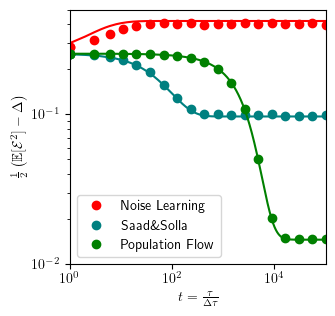

In [68]:
number_of_plotted_points = 20

nonoise_test_errors_simulation = test_errors_simulation - noise/2
nonoise_test_errors_theory = test_errors_theory -noise/2

# nonoise_test_errors_simulation[0] += 7.*noise
# nonoise_test_errors_theory[2] -= noise/2

print(nonoise_test_errors_simulation)
print(nonoise_test_errors_theory)

fig, ax = plt.subplots(figsize=(3.3, 3.3))

for i, gamma in enumerate(gammas):
    plotted_T = np.logspace(0,np.log10(T),num=number_of_plotted_points, dtype=int)
    ax.plot(plotted_T,nonoise_test_errors_simulation[i][plotted_T], marker='o', linestyle='', label=labels_simulations[i], color=colors[i])
    ax.plot(nonoise_test_errors_theory[i], linestyle='-',  color=colors[i])

# ax.legend(gammas)
ax.set_xlabel(r'$t = \frac{\tau}{\Delta\tau}$')
ax.set_ylabel(r'$\frac{1}{2}\left(\mathbb{E}[\mathcal{E}^2]-\Delta\right)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,1e5)
ax.set_ylim(1e-2,5e-1)
ax.legend()

plt.savefig('figures/erf_erf_asymptotics[multindex].pdf', bbox_inches = 'tight')
plt.show()
